In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from utils import *

In [33]:
data = pd.read_csv('./data/MI_timesteps.txt',sep=' ', skiprows=range(1,1001))
data

,timeStep,areaDensityCounting-PID5,areaDensityCounting-PID6,areaDensityCounting-PID7,areaDensityCounting-PID8,areaDensityCounting-PID9,areaDensityCounting-PID10,areaDensityCounting-PID11,areaDensityCounting-PID12,areaDensityCounting-PID13
0,1001,0,2,97,7,0,0,5,1,43
1,1002,0,2,96,7,0,0,5,1,45
2,1003,0,2,95,6,0,0,5,0,46
3,1004,0,2,94,6,0,0,4,1,46
4,1005,0,2,92,6,0,0,5,0,46
...,...,...,...,...,...,...,...,...,...,...
13996,14997,0,10,95,4,0,0,2,1,39
13997,14998,0,10,94,3,0,0,3,1,39
13998,14999,0,10,93,3,0,1,2,1,40
13999,15000,0,10,93,3,0,1,3,1,41


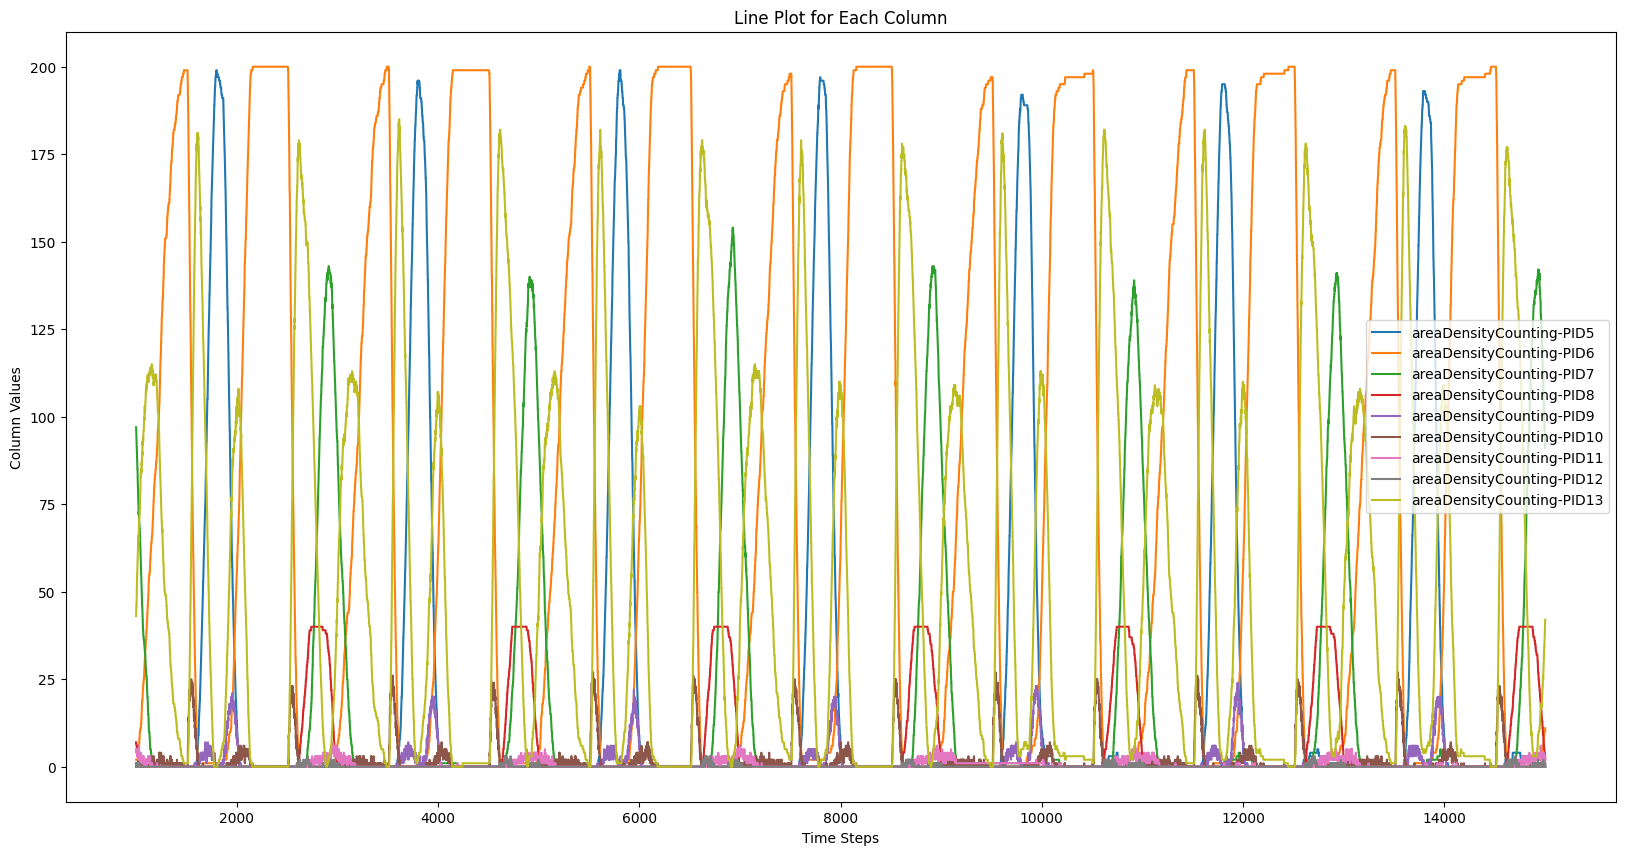

In [34]:
fig = plt.figure(figsize=(20,10))
for column in data.columns[1:]:
    plt.plot(data['timeStep'], data[column], label=column)

plt.xlabel('Time Steps')
plt.ylabel('Column Values')
plt.title('Line Plot for Each Column')
plt.legend()

In [35]:
def create_delay_embedding(data, delay):
    n_rows = len(data) - delay
    embedded_data = np.zeros((n_rows, (delay + 1)*3))

    for i in range(n_rows):
        embedded_data[i] = data.iloc[i:i + delay + 1,1:4].values.flatten()

    return embedded_data

Part 5.1

In [36]:
window_matrix = create_delay_embedding(data,351)
window_matrix.shape

(13650, 1056)

In [37]:
pca = PCA(n_components=3)  
pca_result = pca.fit_transform(window_matrix)
pca_result.shape

(13650, 3)

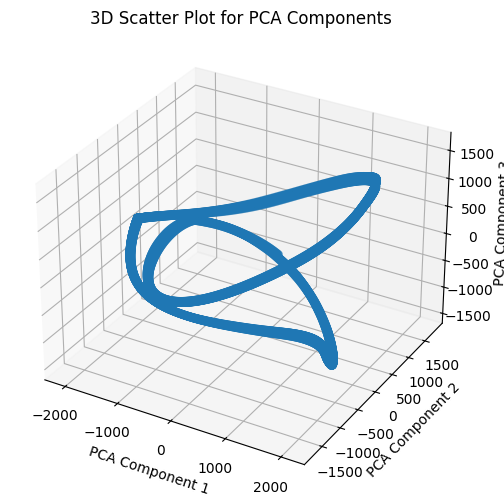

In [38]:
# prepare
x_original = window_matrix[:, :9]  
X_pca = pca_result

# 3D scatter plot for the first three PCA components
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2])
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('3D Scatter Plot for PCA Components')
plt.show()


Part 5.2

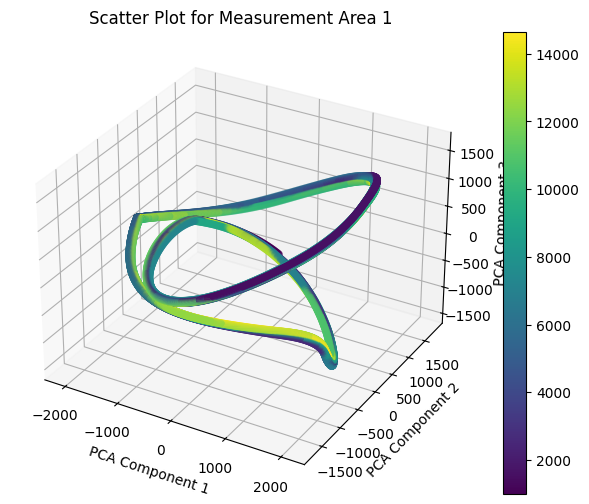

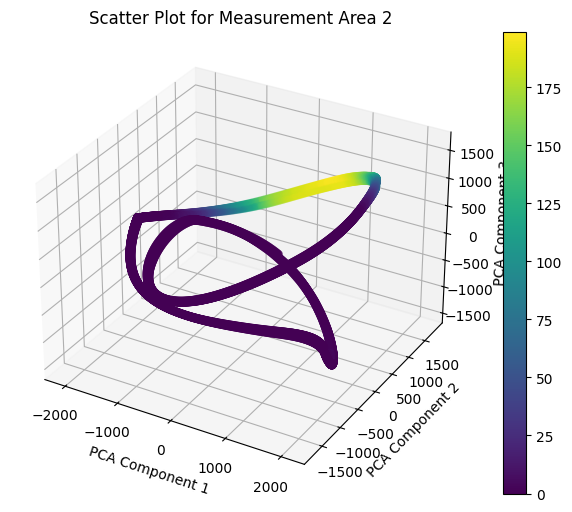

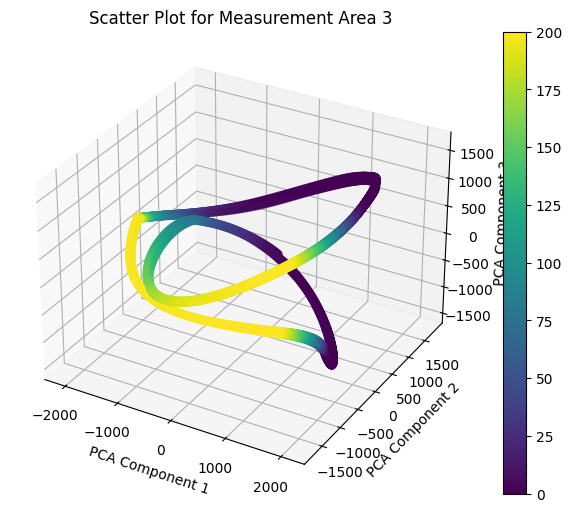

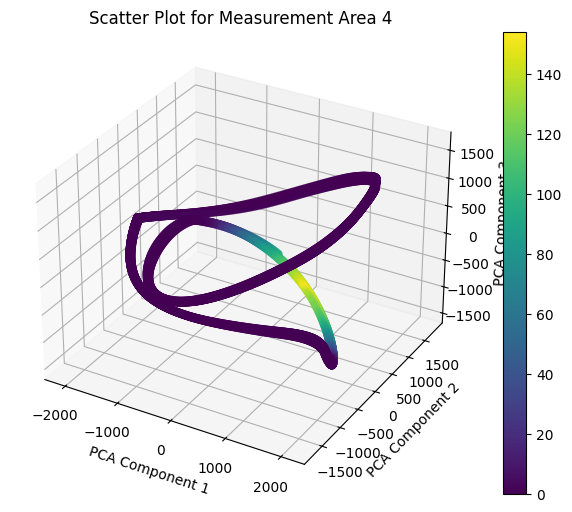

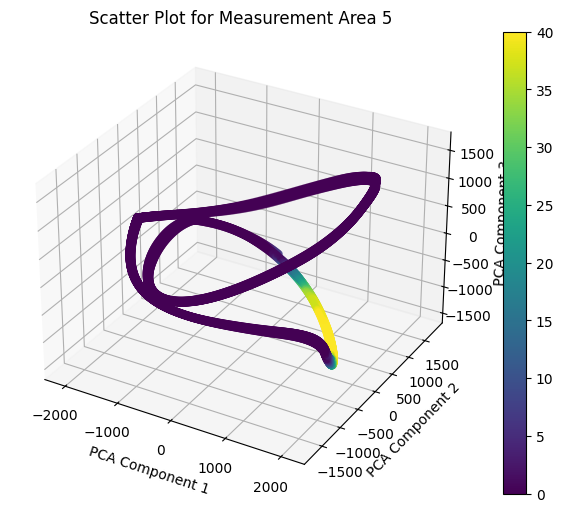

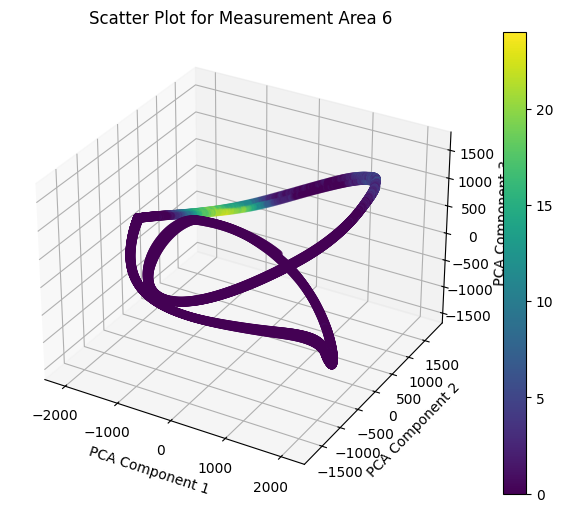

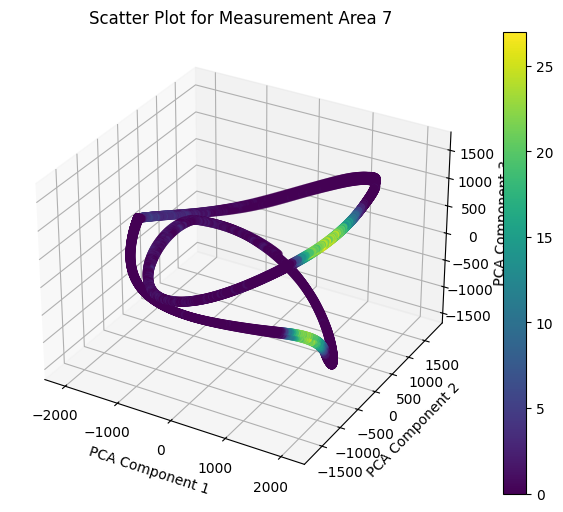

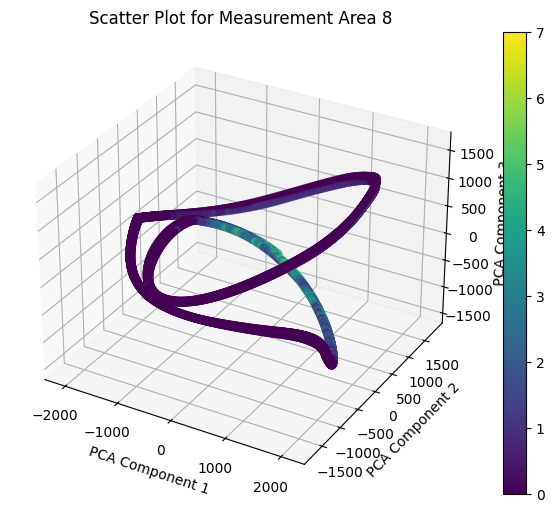

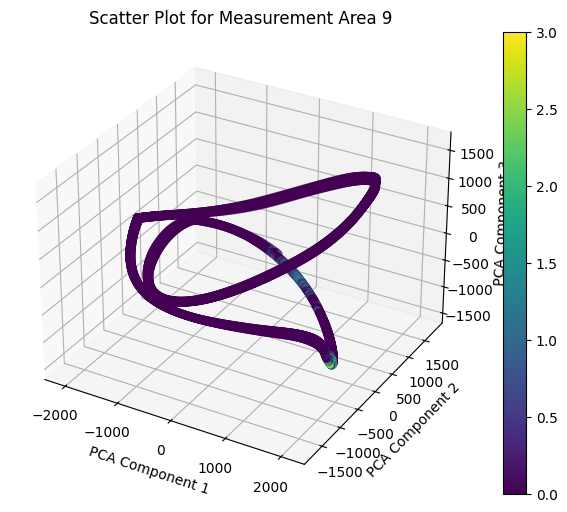

In [39]:
for i in range(9):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Adjust the scatter plot with three components (x, y, z)
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=data.iloc[:len(pca_result), i])
    
    plt.colorbar(scatter)
    ax.set_title(f'Scatter Plot for Measurement Area {i+1}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')

    plt.show()

Part 5.3

In [41]:
def calculate_arclength(pca_data):    
    distances = np.sqrt(np.sum(np.diff(pca_data, axis=0)**2, axis=1))
    arclength = np.cumsum(distances)
    arclength = np.insert(arclength, 0, 0)  # Starting arclength is 0
    return arclength

In [40]:
#Considering the timestep
original_timestamps = data['timeStep']
valid_timestamps = original_timestamps[351:351 + len(pca_result)].reset_index(drop=True)

if len(valid_timestamps) == len(pca_result) :
    print("Length of timestamps does match PCA results")


Length of timestamps does match PCA results


In [42]:
#Calculate the speed
arclength = calculate_arclength(pca_result)
time_differences=np.diff(valid_timestamps)
speed=np.diff(arclength)/time_differences

In [43]:
# Normalize the arclength 
normalized_arclength = (arclength - arclength.min()) / (arclength.max() - arclength.min()) * 2 * np.pi

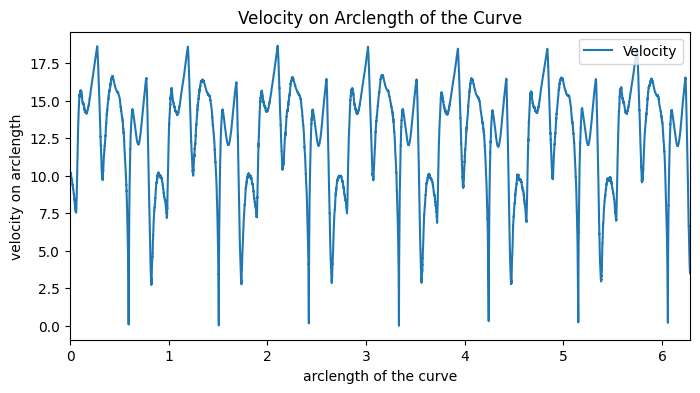

In [44]:
# Plot velocity against normalized arclength
plt.figure(figsize=(8, 4))
plt.plot(normalized_arclength[:-1], speed, label='Velocity')
plt.xlabel('arclength of the curve')
plt.ylabel('velocity on arclength')
plt.title('Velocity on Arclength of the Curve')
plt.xlim([0, 2*np.pi])  
plt.legend()
plt.show()


modeling - sliding windows

In [46]:
def create_sliding_windows(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 5  
X, y = create_sliding_windows(speed, window_size)


In [48]:
split_fraction = 0.8
split_point = int(len(X) * split_fraction)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [49]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [50]:
predictions = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.0031527768285955163


In [54]:
future_steps = 14  # The number of future steps you want to predict
new_input = X_test[-1].reshape(1, -1)  # Start with the last window of observed values from the test set

future_predictions = []
for _ in range(future_steps):
    # Predict the next step and obtain the first (and in this case, only) value
    next_step_prediction = model.predict(new_input)[0]
    
    # Append the predicted value to the list of future predictions
    future_predictions.append(next_step_prediction)
    
    # Update the input window for the next prediction:
    # Roll the window and insert the latest prediction at the end
    new_input = np.roll(new_input, -1)
    new_input[0, -1] = next_step_prediction

# Now, future_predictions contains the predicted values for the future steps.


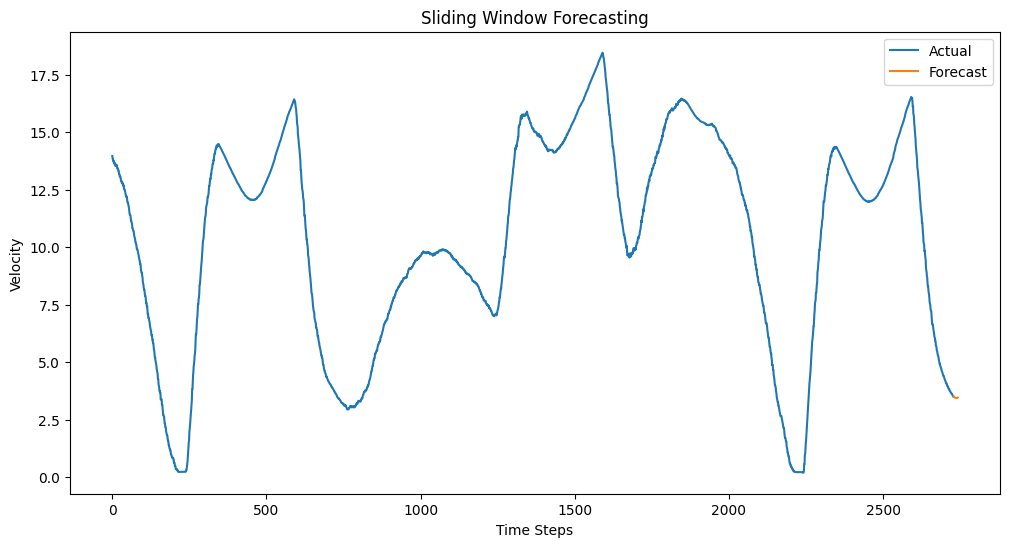

In [55]:
# future_predictions_processed = inverse_preprocessing(future_predictions)

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test)), y_test, label='Actual')
plt.plot(np.arange(len(y_test), len(y_test) + future_steps), future_predictions, label='Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Velocity')
plt.title('Sliding Window Forecasting')
plt.legend()
plt.show()

modeling -lstm 

Part 5.4

Learn the dynamics on the periodic curve you embedded in the principal components.
Predict the utilization of the MI building for the next 14 days
which should look like one of the graphs in figure 3, just about twice as long.